In [1]:
import numpy as np
import tensorflow as tf
from numpy import newaxis
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment
import cv2

In [2]:
class PPOAgent:
    def __init__(self, env, n_actions, n_features, action_low=-1, action_high=1, reward_decay=0.99,
                 actor_learning_rate=0.01, critic_learning_rate=0.01, learning_rate_decay=0.95,
                 ):
        self.env = env
        self.state_size = n_features
        self.action_size = n_actions
        self.action_low = action_low
        self.action_high = action_high
        self.gamma = reward_decay   # discount rate
        self.actor_model_set = True
        self.critic_model_set = True
        self.actor_learning_rate = actor_learning_rate
        self.critic_learning_rate = critic_learning_rate # often larger than actor_learning_rate
        self.learning_rate_decay = learning_rate_decay
        self.batch_size = 64
        self.epsilon = 0.2 # used to clip
        self.entfact = 2e-2 # entropy factor, to encourage exploration
        self.lam = 0.95 # gae factor
        self.memory = [] # store (s, a, r) for one agent
        self.agents = 5 # number of agents that collect memory
        self.history = {} # store the memory for different agents
        self.history['states'] = []
        self.history['observations'] = []
        self.history['actions'] = []
        self.history['discounted_rs'] = []
        self.history['advantages'] = []
        self._construct_nets()
        
    def _construct_nets(self):
        self.sess = tf.Session()
        self.tfs = tf.placeholder(tf.float32, [None, self.state_size], 'state')
        self.obs = tf.placeholder(tf.float32, [None, 16, 40, 1], 'observation')

        # critic
        with tf.variable_scope('critic'):
#             net = tf.layers.conv2d(self.obs,
#                                    filters=10,
#                                    kernel_size=[5, 5],
#                                    padding="same",
#                                    activation=tf.nn.relu)
#             net = tf.nn.relu(tf.layers.batch_normalization(net))
#             net = tf.layers.max_pooling2d(net, pool_size=[2, 2], strides=2)
#             net = tf.layers.conv2d(net,
#                                    filters=32,
#                                    kernel_size=[5, 5],
#                                    padding="same",
#                                    activation=tf.nn.relu)
#             net = tf.layers.max_pooling2d(net, pool_size=[3, 3], strides=3)
            n_l1_c = 128
            net = tf.reshape(self.obs, [-1, 16*40])
            w1_c_ob = tf.get_variable('w1_c_ob', [16*40, n_l1_c])
            w1_c_s = tf.get_variable('w1_c_s', [self.state_size, n_l1_c])
            b1_c = tf.get_variable('b1_c', [1, n_l1_c])
            net = tf.nn.relu(tf.matmul(net, w1_c_ob) + tf.matmul(self.tfs, w1_c_s) + b1_c)
            net = tf.layers.dense(net, 32, tf.nn.relu)
            self.v = tf.layers.dense(net, 1)
            self.tfdc_r = tf.placeholder(tf.float32, [None, 1], 'discounted_r')
            self.closs = tf.reduce_mean(tf.square(self.tfdc_r - self.v))
            self.ctrain_op = tf.train.AdamOptimizer(self.critic_learning_rate).minimize(self.closs)

        # actor
        pi, pi_params = self._build_anet('pi', trainable=True)
        test_pi = tf.distributions.Normal(loc=pi.mean(), scale=tf.zeros_like(pi.stddev()))
        oldpi, oldpi_params = self._build_anet('oldpi', trainable=False)
        with tf.variable_scope('sample_action'):
            self.sample_op = tf.squeeze(pi.sample(1), axis=0)       # choosing action
            self.sample_test = tf.squeeze(test_pi.sample(1), axis=0) # deterministic action in test
        with tf.variable_scope('update_oldpi'):
            self.update_oldpi_op = [oldp.assign(p) for p, oldp in zip(pi_params, oldpi_params)]

        self.tfa = tf.placeholder(tf.float32, [None, self.action_size], 'action')
        self.tfadv = tf.placeholder(tf.float32, [None, 1], 'advantage')
        with tf.variable_scope('loss'):
            with tf.variable_scope('surrogate'):
                self.ratio = pi.prob(self.tfa) / (oldpi.prob(self.tfa)+1e-10)
                surr = self.ratio * self.tfadv
                surr2 = tf.clip_by_value(self.ratio, 1-self.epsilon, 1+self.epsilon) * self.tfadv
                self.aloss = - tf.reduce_mean(tf.minimum(surr, surr2)) - self.entfact * tf.reduce_mean(pi.entropy())

        with tf.variable_scope('atrain'):
            self.atrain_op = tf.train.AdamOptimizer(self.actor_learning_rate).minimize(self.aloss, var_list=pi_params)

        self.saver = tf.train.Saver()
        
        self.sess.run(tf.global_variables_initializer())
        
    def _build_anet(self, name, trainable):
        with tf.variable_scope(name):
#             net = tf.layers.conv2d(self.obs,
#                                    filters=5,
#                                    kernel_size=[3, 3],
#                                    padding="same",
#                                    activation=tf.nn.relu,
#                                    trainable=trainable)
#             net = tf.layers.max_pooling2d(net, pool_size=[2, 2], strides=2)
#             net = tf.layers.conv2d(net,
#                                    filters=32,
#                                    kernel_size=[5, 5],
#                                    padding="same",
#                                    activation=tf.nn.relu,
#                                    trainable=trainable)
#             net = tf.layers.max_pooling2d(net, pool_size=[3, 3], strides=3)
            n_l1_a = 128
            net = tf.reshape(self.obs, [-1, 16*40])
            w1_a_ob = tf.get_variable('w1_a_ob', [16*40, n_l1_a], trainable=trainable)
            w1_a_s = tf.get_variable('w1_a_s', [self.state_size, n_l1_a], trainable=trainable)
            b1_a = tf.get_variable('b1_a', [1, n_l1_a], trainable=trainable)
            net = tf.nn.relu(tf.matmul(net, w1_a_ob) + tf.matmul(self.tfs, w1_a_s) + b1_a)
            net = tf.layers.dense(net, 32, tf.nn.relu, trainable=trainable)
#             net = tf.layers.dense(net, 512, trainable=trainable)
#             net = tf.nn.relu(tf.layers.batch_normalization(net))
            mu = max(np.abs(self.action_low), np.abs(self.action_high)) * tf.layers.dense(net, self.action_size, tf.nn.tanh, trainable=trainable)
            sigma = tf.layers.dense(net, self.action_size, tf.nn.softplus, trainable=trainable)
            norm_dist = tf.distributions.Normal(loc=mu, scale=sigma)
        params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=name)
        return norm_dist, params
    
    def choose_action(self, state, observation, train=True): # normal distribution
        assert self.actor_model_set, 'actor model not set!'
        if train:
            a = self.sess.run(self.sample_op, {self.tfs: state, self.obs: observation})[0]
        else:
            a = self.sess.run(self.sample_test, {self.tfs: state, self.obs: observation})[0]
        return np.clip(a, self.action_low, self.action_high)
    
    def remember(self, state, observation, action, reward, next_state, next_observation):
        self.memory += [[state[0], observation[0], action, reward, next_state[0], next_observation[0]]]
    
    def discount_rewards(self, rewards, gamma, value_next=0.0):
        discounted_r = np.zeros_like(rewards)
        running_add = value_next
        for t in reversed(range(0, len(rewards))):
            discounted_r[t] = running_add = running_add * gamma + rewards[t]
        return discounted_r
    
    def process_memory(self):
        memory = np.vstack(self.memory)
        states = np.vstack(memory[:,0])
        observations = np.vstack(memory[:,1]).reshape((-1,16,40,1))
        actions = np.vstack(memory[:,2])
        rewards = memory[:,3]
        last_next_state = memory[:,4][-1]
        last_next_observation = memory[:,5][-1]
        discounted_ep_rs = self.discount_rewards(rewards, self.gamma)[:, newaxis]
        value_estimates = self.sess.run(self.v, {self.tfs: states, self.obs: observations}).flatten()
#         value_estimates = self.sess.run(self.v, {self.tfs: np.r_[states, last_next_state[newaxis, :]], 
#                                                  self.obs: np.r_[observations, last_next_observation[newaxis, :]]}).flatten()
#         last_value_estimate = self.sess.run(self.v, {self.tfs: , self.obs: })[0]
        value_estimates = np.append(value_estimates, 0)
        delta_t = rewards + self.gamma * value_estimates[1:] - value_estimates[:-1]
        advs = self.discount_rewards(delta_t, self.gamma * self.lam)[:, newaxis] #gae
        last = states.shape[0] #min(500, states.shape[0])
        self.history['states'] += [states[-last:]]
        self.history['observations'] += [observations[-last:]]
        self.history['actions'] += [actions[-last:]]
        self.history['discounted_rs'] += [discounted_ep_rs[-last:]]
        self.history['advantages'] += [advs[-last:]]
        self.memory = [] # empty the memory
    
    def replay(self):
        assert self.actor_model_set, 'model not set!'
        assert self.critic_model_set, 'critic model not set!'
        self.sess.run(self.update_oldpi_op)
        
        s = np.vstack(self.history['states'])
        ob = np.vstack(self.history['observations'])
        ac = np.vstack(self.history['actions'])
        dc_r = np.vstack(self.history['discounted_rs'])
        ad = np.vstack(self.history['advantages'])
#         ad = (ad-ad.mean())/ad.std()
        
        for _ in range(10): # update K epochs
            s, ob, ac, dc_r, ad = shuffle(s, ob, ac, dc_r, ad)
            for l in range(s.shape[0]//self.batch_size):
                start = l * self.batch_size
                end = (l + 1) * self.batch_size
                self.sess.run(self.atrain_op, {self.tfs: s[start:end, :], self.obs:ob[start:end, :], self.tfa: ac[start:end, :], self.tfadv: ad[start:end, :]})
                self.sess.run(self.ctrain_op, {self.tfs: s[start:end, :], self.obs:ob[start:end, :], self.tfdc_r: dc_r[start:end, :]})
            if s.shape[0] % self.batch_size != 0:
                res = s.shape[0] % self.batch_size
                self.sess.run(self.atrain_op, {self.tfs: s[-res:, :], self.obs:ob[-res:, :], self.tfa: ac[-res:, :], self.tfadv: ad[-res:, :]})
                self.sess.run(self.ctrain_op, {self.tfs: s[-res:, :], self.obs:ob[-res:, :], self.tfdc_r: dc_r[-res:, :]})
#         self.actor_learning_rate *= self.learning_rate_decay
#         self.critic_learning_rate *= self.learning_rate_decay
        
        for key in self.history:
            self.history[key] = [] # empty the history

In [3]:
env_name = "autocar2_tmp"
env = UnityEnvironment(file_name=env_name)

# Examine environment parameters
print(str(env))

# Set the default brain to work with
default_brain = env.brain_names[0]
brain = env.brains[default_brain]

INFO:unityagents.environment:
'Academy' started successfully!


Unity Academy name: Academy
        Number of brains: 1
        Reset Parameters :
		
Unity brain name: Brain
        Number of observations (per agent): 1
        State space type: continuous
        State space size (per agent): 1
        Action space type: continuous
        Action space size (per agent): 2
        Memory space size (per agent): 0
        Action descriptions: , 


In [4]:
def edges(img, thr1=100, thr2=150):
    imgBlur = cv2.GaussianBlur(img, (5, 5), 0)
    edges = cv2.Canny(np.uint8(imgBlur*255),thr1,thr2)/255
    return edges.reshape(-1,*edges.shape,1)

In [5]:
def showEdges(img, thr1=100, thr2=150):
    imgBlur = cv2.GaussianBlur(img, (5, 5), 0)
    edges = cv2.Canny(np.uint8(imgBlur*255),thr1,thr2)/255
    # gr = img[...,:3].dot([0.299, 0.587, 0.114])
    plt.subplots(figsize=(15,15))
    plt.subplot(131), plt.xticks([]), plt.yticks([]), plt.title('Original Image')
    plt.imshow(img)
    plt.subplot(132), plt.xticks([]), plt.yticks([]), plt.title('Blurred Image')
    plt.imshow(imgBlur)
    plt.subplot(133), plt.xticks([]), plt.yticks([]), plt.title('Edges')
    plt.imshow(edges, cmap='gray')
    plt.show()

(1, 16, 40, 3)
[ 0.]


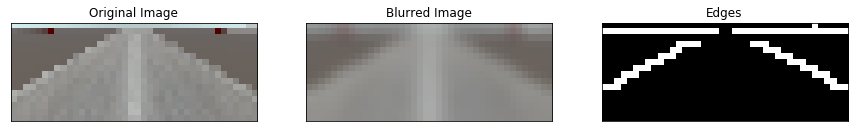

In [6]:
# Reset the environment
env_info = env.reset(train_mode=False)[default_brain]

print(env_info.observations[0].shape)
print(env_info.states[0])

img = env_info.observations[0][0]
showEdges(img)

## Test the camera

In [7]:
for i in range(40):
    for _ in range(10):
        env_info = env.step([1,0])[default_brain]
#     print(str((i+1)*10)+' steps')
    img = env_info.observations[0][0]
    if i==0:
        sky = img[:3,:]
    else:
        sky += img[:3,:]
#     showEdges(img)
sky /= 40
print('State is :', env_info.states[0])

State is : [ 10.6972027]


## Sky

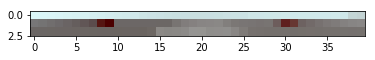

In [8]:
plt.imshow(sky)
plt.show()

# PPO agent

In [9]:
agent = PPOAgent(env,
                n_actions=2,
                n_features=1,
                actor_learning_rate=1e-5,
                critic_learning_rate=2e-5
                )
rewards = []

In [10]:
# PPO
n_episodes = 200

agent.saver.restore(agent.sess, "model/model_ppo.ckpt")
for i_episode in range(n_episodes):
    env_info = agent.env.reset(train_mode=True)[default_brain]
    state = env_info.states
    env_info.observations[0][0][:3,:] = sky # pretend that we always see the sky above
    observation = edges(env_info.observations[0][0])
    r = 0
    while True:
        action = agent.choose_action(state, observation)
        env_info = agent.env.step(action)[default_brain]
        next_state = env_info.states
        env_info.observations[0][0][:3,:] = sky # pretend that we always see the sky above
        next_observation = edges(env_info.observations[0][0])
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        r += reward
        agent.remember(state, observation, action, reward, next_state, next_observation)
        state = next_state
        observation = next_observation
        if done:
            print("episode:", i_episode+1, "rewards: %.2f" % r, end="\r")
            agent.process_memory()
            rewards += [r]
            break
    if (i_episode+1) % agent.agents == 0: # update every n_agent episodes
        agent.replay()
#     if (i_episode+1) % 100 == 0:
#         agent.saver.save(agent.sess, "model/model2_ppo.ckpt");
agent.saver.save(agent.sess, "model/model2_ppo.ckpt");
print("\n")
print("finished learning!")

INFO:tensorflow:Restoring parameters from model/model_ppo.ckpt


INFO:tensorflow:Restoring parameters from model/model_ppo.ckpt


episode: 200 rewards: 9560.212

finished learning!


In [ ]:
#ppo
n_episodes = 1

test_rewards = []
# agent.saver.restore(agent.sess, "model/model2_ppo_good.ckpt")
for i_episode in range(n_episodes):
    env_info = agent.env.reset(train_mode=False)[default_brain]
    state = env_info.states
    env_info.observations[0][0][:3,:] = sky # pretend that we always see the sky above
    observation = edges(env_info.observations[0][0])
    r = 0
    while True:
        action = agent.choose_action(state, observation)
        env_info = agent.env.step(action)[default_brain]
        state = env_info.states
        env_info.observations[0][0][:3,:] = sky
        observation = edges(env_info.observations[0][0])
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        r += reward
        if done:
            print("episode:", i_episode+1, "rewards: %.2f" % r, end="\r")
            test_rewards += [r]
            break
print("\n")
print("finished testing!")

# Plot reward

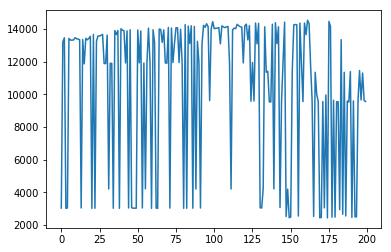

10428.4595583


In [11]:
plt.plot(rewards)
plt.show()
print(np.mean(rewards))

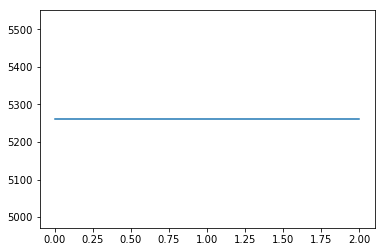

In [10]:
plt.plot(test_rewards)
plt.show()

In [11]:
env.close()